In [14]:
import numpy as np
from glob import glob
import os
import healpy as hp
import matplotlib.pyplot as plt
import seaborn as sns
import logging

from src.utils.ConfigData import ConfigAnalysis

logging.basicConfig(level=logging.ERROR)

In [2]:
def load_data(files):
    data = []
    for filename in files:
        data.append(np.load(filename))
    return data

def calculate_bin_counts(data, peak_bins, minima_bins):
    peak_bin_counts = np.zeros((len(data), len(peak_bins) - 1))
    minima_bin_counts = np.zeros((len(data), len(minima_bins) - 1))
    
    for i, d in enumerate(data):
        peak_bin_counts[i], _ = np.histogram(d['peak_height'], bins=peak_bins)
        minima_bin_counts[i], _ = np.histogram(d['minima_height'], bins=minima_bins)
        
    return peak_bin_counts, minima_bin_counts

def compute_covariance(bin_counts):
    covariance_matrix = np.cov(bin_counts, rowvar=False)
    diagonal_terms = np.diag(covariance_matrix)
    return diagonal_terms, covariance_matrix

# Peaks Minima

In [3]:
config_path = "/lustre/work/akira.tokiwa/Projects/LensingSSC/configs/config_analysis.json"
config_analysis = ConfigAnalysis.from_json(config_path)

def get_files(config_id, source_redshift=0.5, smoothing_length=0.0):
    results_directory = os.path.join(config_analysis.resultsdir, config_id)
    return glob(os.path.join(results_directory, "peakminima", "smoothed_patch_flat", 
                                f"zs{source_redshift:.1f}", f"sl{str(smoothing_length)}", "*.npz"))

In [10]:
zs_list = [0.5, 1.0, 2.0]
sl_list = [5, 8, 10]
bins_list = []
peak_covariances = []
minima_covariances = []
correlation_differences =[]
for source_redshift in zs_list:
    for smoothing_length in sl_list:
        logging.info(f"source_redshift: {source_redshift}, smoothing_length: {smoothing_length}")
        #fullsky_file_tiled = os.path.join(config_analysis.resultsdir, "tiled", "smoothed", f"kappa_zs{source_redshift:.1f}_smoothed_s{str(smoothing_length)}.fits")
        fullsky_file_bigbox = os.path.join(config_analysis.resultsdir, "bigbox", "smoothed", f"kappa_zs{source_redshift:.1f}_smoothed_s{str(smoothing_length)}.fits")

        #fullsky_map_tiled = hp.reorder(hp.read_map(fullsky_file_tiled), n2r=True)
        #sigma_tiled = np.std(fullsky_map_tiled)

        fullsky_map_bigbox = hp.reorder(hp.read_map(fullsky_file_bigbox), n2r=True)
        sigma_bigbox = np.std(fullsky_map_bigbox)
        logging.info(f"sigma_bigbox: {sigma_bigbox}")

        files1 = get_files("tiled", source_redshift, smoothing_length)
        files2 = get_files("bigbox", source_redshift, smoothing_length)
        
        data1 = load_data(files1)
        data2 = load_data(files2)
        
        #bins_tiled = np.linspace(-4, 4, 15, endpoint=True) * sigma_tiled
        bins_bigbox = np.linspace(-4, 4, 15, endpoint=True) * sigma_bigbox

        peak_bin_counts1, minima_bin_counts1 = calculate_bin_counts(data1, bins_bigbox, bins_bigbox)
        peak_bin_counts2, minima_bin_counts2 = calculate_bin_counts(data2, bins_bigbox, bins_bigbox)

        peak_diagonal_terms1, peak_covariance1 = compute_covariance(peak_bin_counts1)
        peak_diagonal_terms2, peak_covariance2 = compute_covariance(peak_bin_counts2)

        minima_diagonal_terms1, minima_covariance1 = compute_covariance(minima_bin_counts1)
        minima_diagonal_terms2, minima_covariance2 = compute_covariance(minima_bin_counts2)

        peak_correlation1 = peak_covariance1 / np.sqrt(np.abs(peak_diagonal_terms1[:, None] * peak_diagonal_terms1[None, :]))
        peak_correlation2 = peak_covariance2 / np.sqrt(np.abs(peak_diagonal_terms2[:, None] * peak_diagonal_terms2[None, :]))

        minima_correlation1 = minima_covariance1 / np.sqrt(np.abs(minima_diagonal_terms1[:, None] * minima_diagonal_terms1[None, :]))
        minima_correlation2 = minima_covariance2 / np.sqrt(np.abs(minima_diagonal_terms2[:, None] * minima_diagonal_terms2[None, :]))

        peak_correlation_difference = peak_correlation2 - peak_correlation1

        minima_correlation_difference = minima_correlation2 - minima_correlation1

        correlation_differences.append((peak_correlation_difference, minima_correlation_difference))
        bins_list.append(bins_bigbox)
        peak_covariances.append((peak_covariance1, peak_covariance2))
        minima_covariances.append((minima_covariance1, minima_covariance2))

2024-06-06 02:47:42,945 - root - INFO - source_redshift: 0.5, smoothing_length: 5
2024-06-06 02:47:42,954 - healpy - INFO - NSIDE = 8192
2024-06-06 02:47:42,954 - healpy - INFO - ORDERING = RING in fits file
2024-06-06 02:47:42,955 - healpy - INFO - INDXSCHM = IMPLICIT
2024-06-06 02:48:08,721 - root - INFO - sigma_bigbox: 0.0038753850385546684
/var/tmp/pbs.253104.idark/ipykernel_58070/149965913.py:38: RuntimeWarning: invalid value encountered in true_divide
  peak_correlation1 = peak_covariance1 / np.sqrt(np.abs(peak_diagonal_terms1[:, None] * peak_diagonal_terms1[None, :]))
/var/tmp/pbs.253104.idark/ipykernel_58070/149965913.py:39: RuntimeWarning: invalid value encountered in true_divide
  peak_correlation2 = peak_covariance2 / np.sqrt(np.abs(peak_diagonal_terms2[:, None] * peak_diagonal_terms2[None, :]))
/var/tmp/pbs.253104.idark/ipykernel_58070/149965913.py:41: RuntimeWarning: invalid value encountered in true_divide
  minima_correlation1 = minima_covariance1 / np.sqrt(np.abs(minima

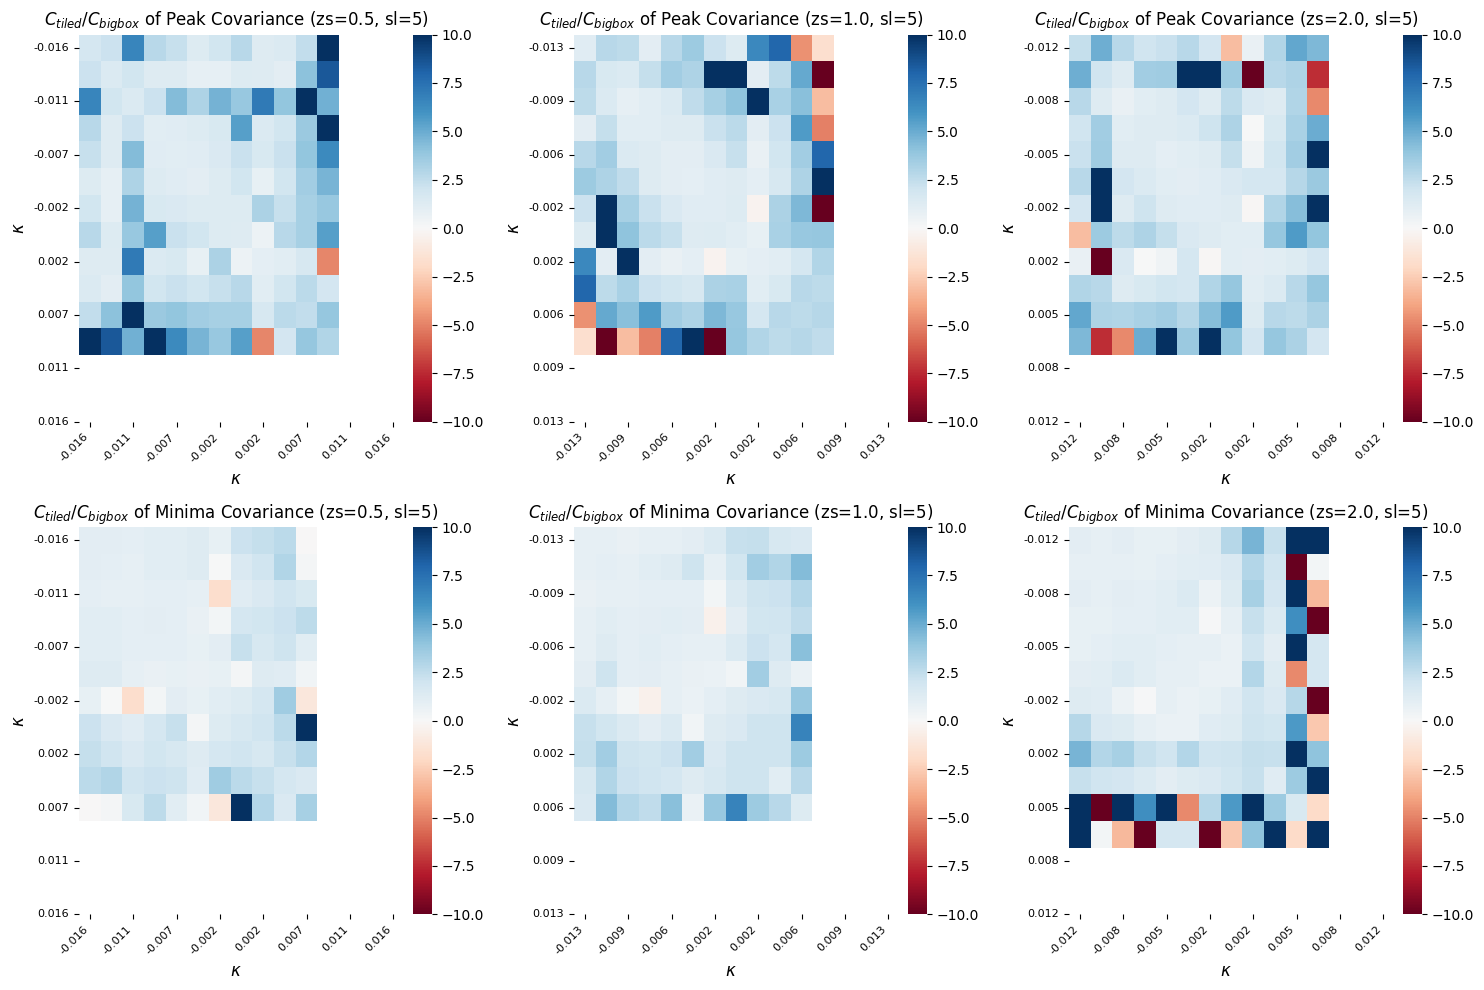

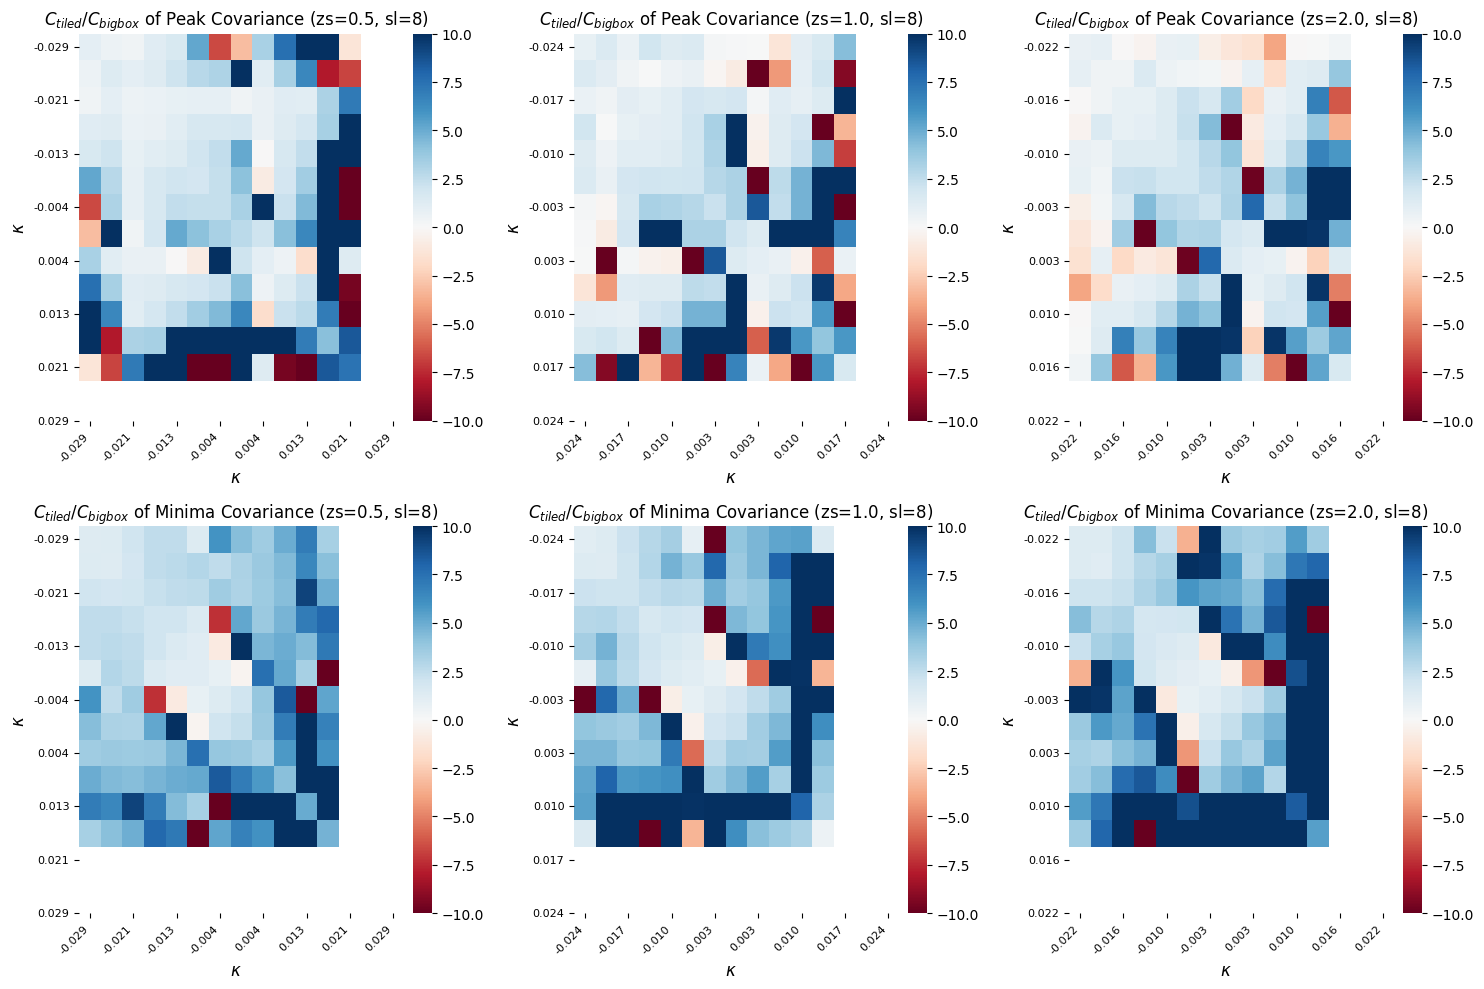

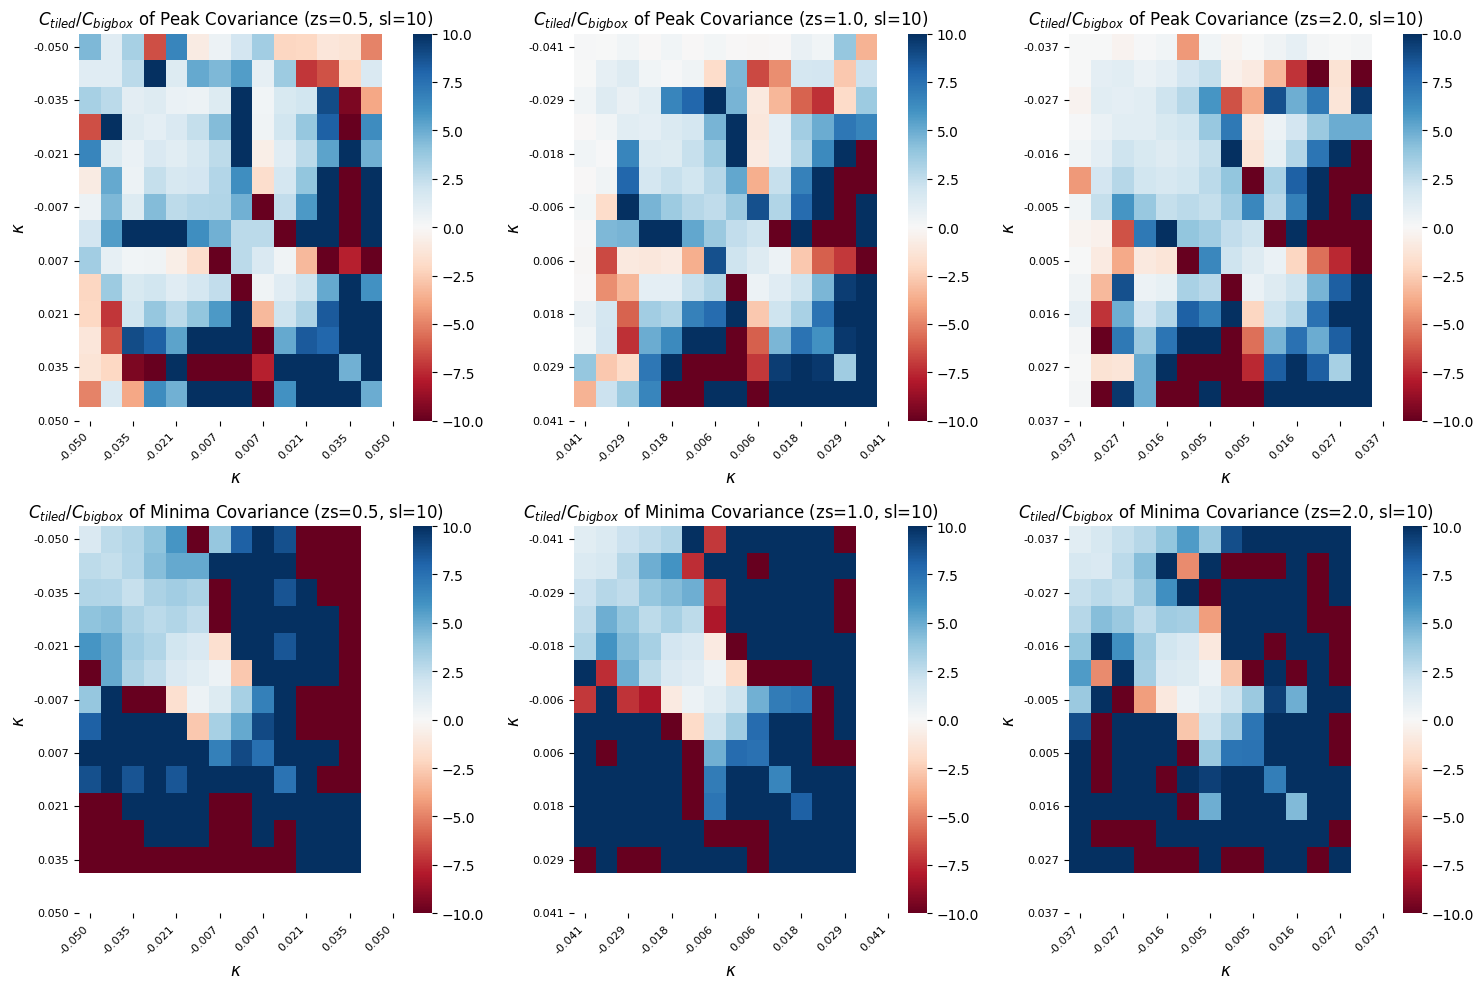

In [28]:
tick_interval = 2
np.seterr(divide='ignore', invalid='ignore')

# Loop through each smoothing length
for sl_index, smoothing_length in enumerate(sl_list):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Loop through each source redshift
    for zs_index, source_redshift in enumerate(zs_list):
        # Ensure we access the correct index
        correlation_index = sl_index * len(zs_list) + zs_index
        peak_covariance1, peak_covariance2 = peak_covariances[correlation_index]
        minima_covariance1, minima_covariance2 = minima_covariances[correlation_index]
        peak_covariance_ratio = peak_covariance1 / peak_covariance2
        peak_covariance_ratio[np.isinf(peak_covariance_ratio)] = np.nan
        minima_covariance_ratio = minima_covariance1 / minima_covariance2
        minima_covariance_ratio[np.isinf(minima_covariance_ratio)] = np.nan
        bins = bins_list[correlation_index]

        # Plot "Peaks" at the top row
        ax_peak = axes[zs_index]
        sns.heatmap(peak_covariance_ratio, ax=ax_peak, cmap='RdBu', center=0, xticklabels=bins, yticklabels=bins, vmin=-10, vmax=10)
        ax_peak.set_title(r"$C_{tiled}/C_{bigbox}$"+" of Peak Covariance (zs={:.1f}, sl={})".format(source_redshift, smoothing_length))
        ax_peak.set_xticks(ax_peak.get_xticks()[::tick_interval])
        ax_peak.set_xticklabels([f'{tick:.3f}' for tick in bins[::tick_interval]], rotation=45, ha='right', fontsize=8)
        ax_peak.set_yticks(ax_peak.get_yticks()[::tick_interval])
        ax_peak.set_yticklabels([f'{tick:.3f}' for tick in bins[::tick_interval]], rotation=0, fontsize=8)
        ax_peak.set_xlabel(r'$\kappa$', fontsize=12)
        ax_peak.set_ylabel(r'$\kappa$', fontsize=12)

        # Plot "Minima" at the bottom row
        ax_minima = axes[zs_index + 3]
        sns.heatmap(minima_covariance_ratio, ax=ax_minima, cmap='RdBu', center=0, xticklabels=bins, yticklabels=bins, vmin=-10, vmax=10)
        ax_minima.set_title(r"$C_{tiled}/C_{bigbox}$"+" of Minima Covariance (zs={:.1f}, sl={})".format(source_redshift, smoothing_length))
        ax_minima.set_xticks(ax_minima.get_xticks()[::tick_interval])
        ax_minima.set_xticklabels([f'{tick:.3f}' for tick in bins[::tick_interval]], rotation=45, ha='right', fontsize=8)
        ax_minima.set_yticks(ax_minima.get_yticks()[::tick_interval])
        ax_minima.set_yticklabels([f'{tick:.3f}' for tick in bins[::tick_interval]], rotation=0, fontsize=8)
        ax_minima.set_xlabel(r'$\kappa$', fontsize=12)
        ax_minima.set_ylabel(r'$\kappa$', fontsize=12)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

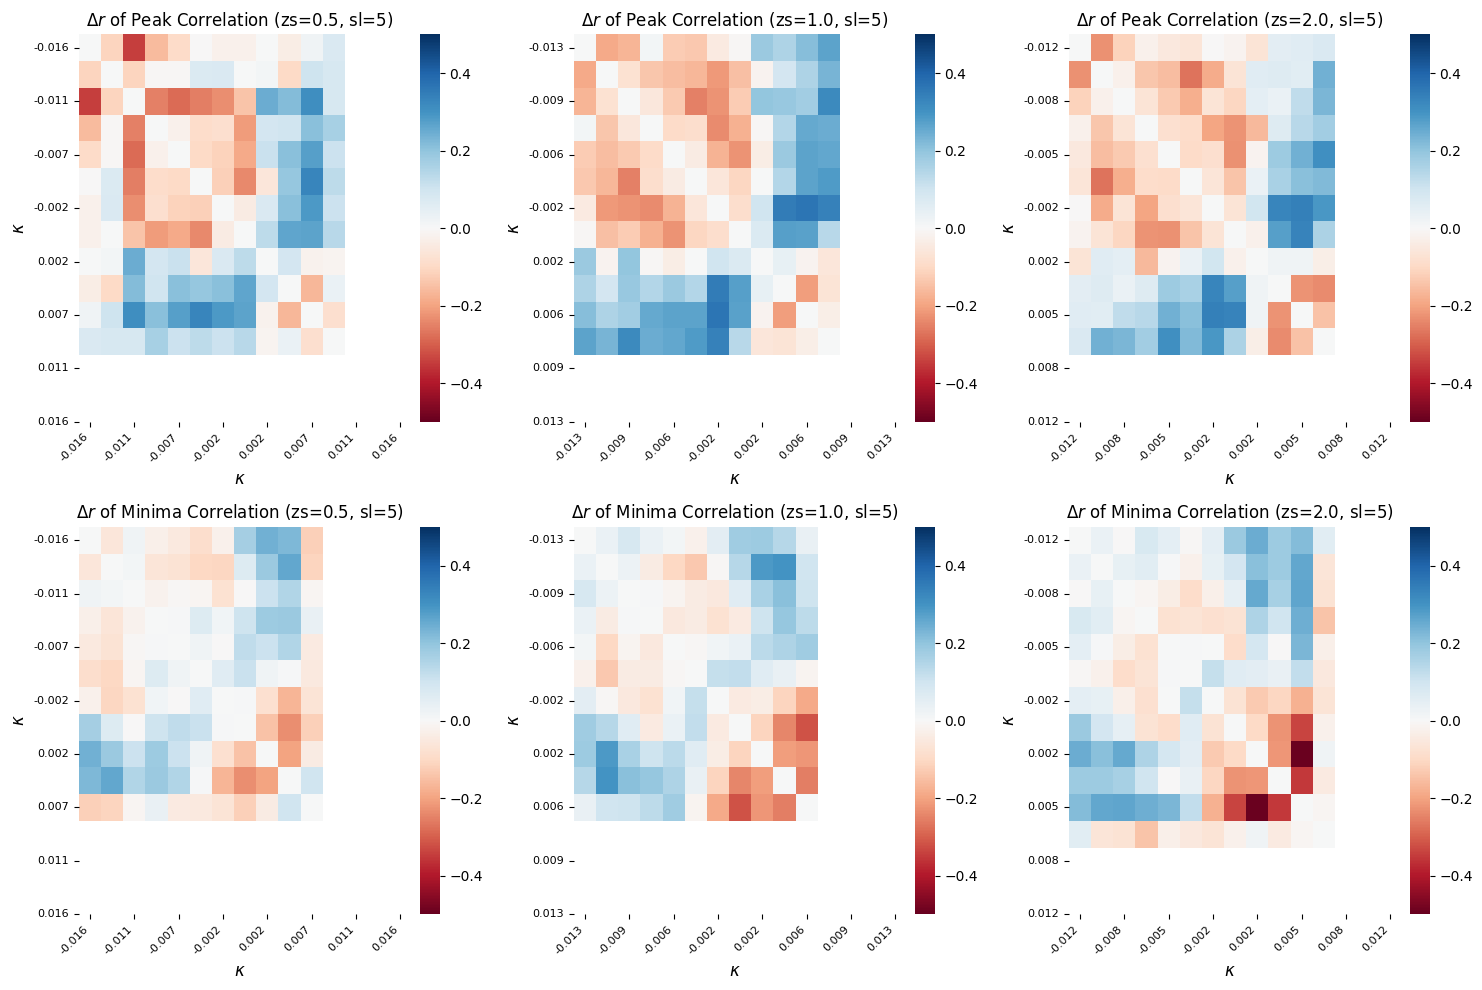

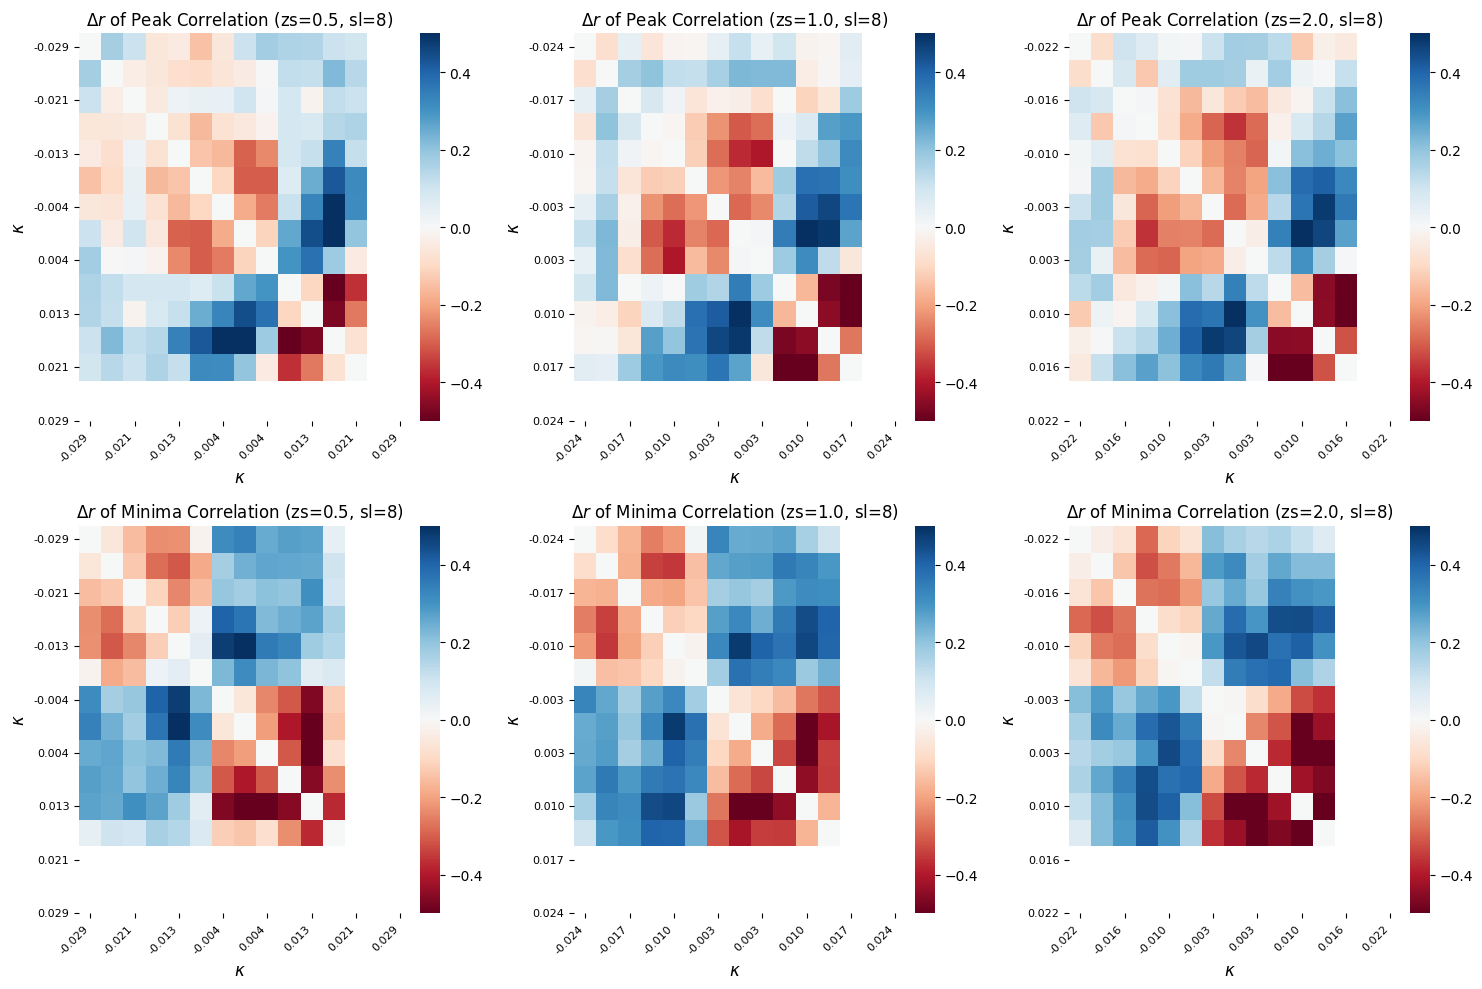

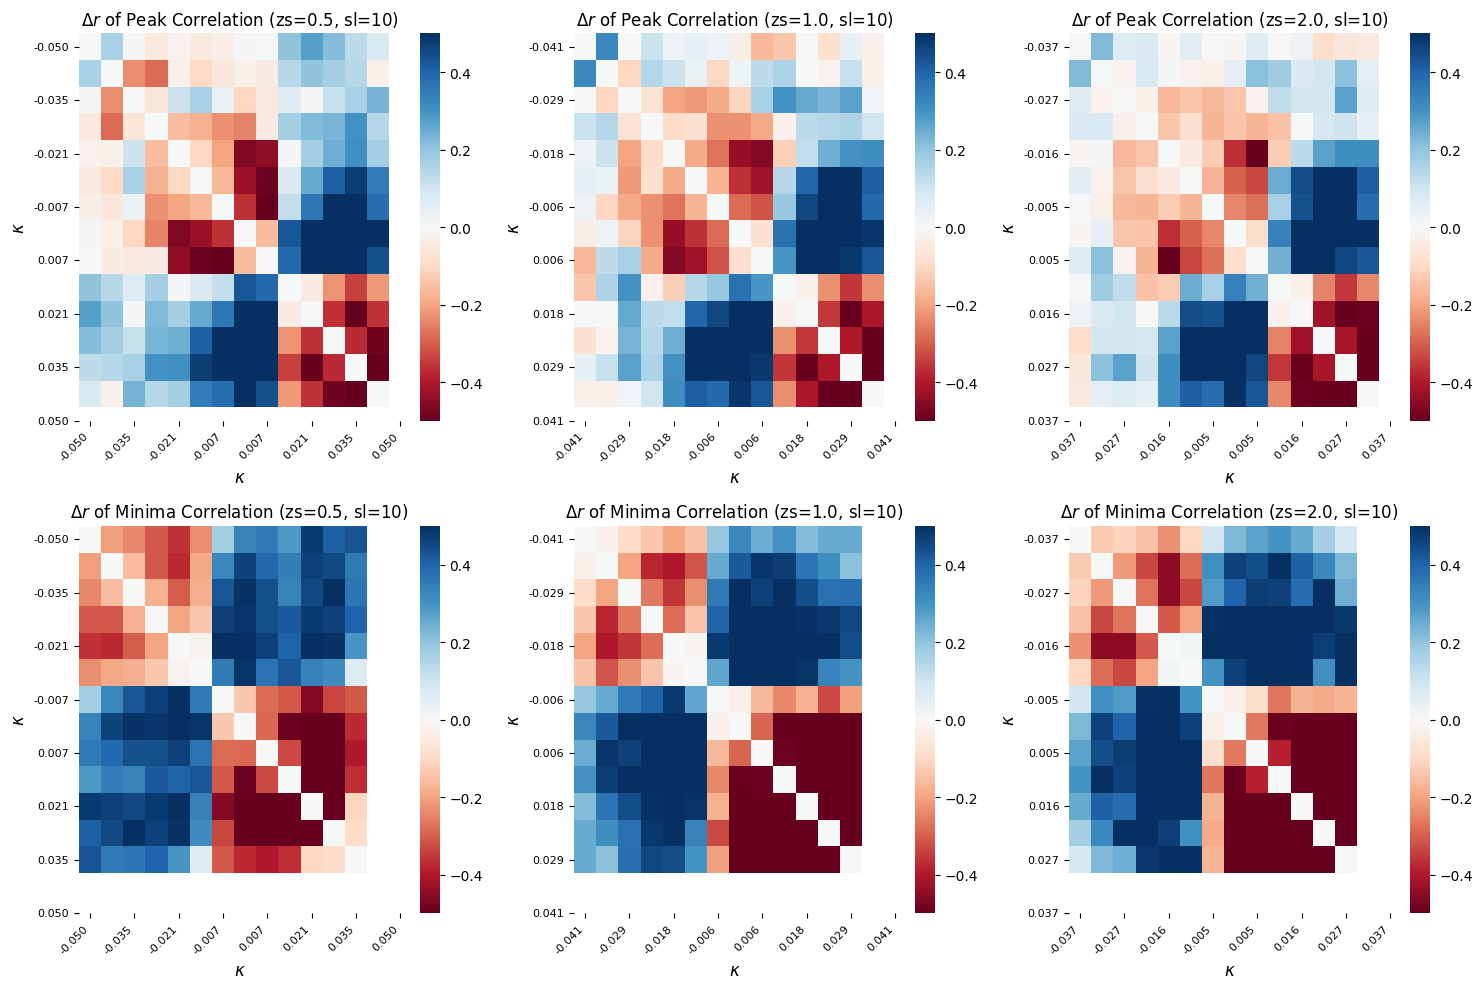

In [19]:
tick_interval = 2

# Loop through each smoothing length
for sl_index, smoothing_length in enumerate(sl_list):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Loop through each source redshift
    for zs_index, source_redshift in enumerate(zs_list):
        # Ensure we access the correct index
        correlation_index = sl_index * len(zs_list) + zs_index
        peak_correlation_difference, minima_correlation_difference = correlation_differences[correlation_index]
        bins = bins_list[correlation_index]

        # Plot "Peaks" at the top row
        ax_peak = axes[zs_index]
        sns.heatmap(peak_correlation_difference, ax=ax_peak, cmap='RdBu', center=0, xticklabels=bins, yticklabels=bins, vmin=-0.5, vmax=0.5)
        ax_peak.set_title(r"$\Delta r$"+" of Peak Correlation (zs={:.1f}, sl={})".format(source_redshift, smoothing_length))
        ax_peak.set_xticks(ax_peak.get_xticks()[::tick_interval])
        ax_peak.set_xticklabels([f'{tick:.3f}' for tick in bins[::tick_interval]], rotation=45, ha='right', fontsize=8)
        ax_peak.set_yticks(ax_peak.get_yticks()[::tick_interval])
        ax_peak.set_yticklabels([f'{tick:.3f}' for tick in bins[::tick_interval]], rotation=0, fontsize=8)
        ax_peak.set_xlabel(r'$\kappa$', fontsize=12)
        ax_peak.set_ylabel(r'$\kappa$', fontsize=12)

        # Plot "Minima" at the bottom row
        ax_minima = axes[zs_index + 3]
        sns.heatmap(minima_correlation_difference, ax=ax_minima, cmap='RdBu', center=0, xticklabels=bins, yticklabels=bins, vmin=-0.5, vmax=0.5)
        ax_minima.set_title(r"$\Delta r$"+" of Minima Correlation (zs={:.1f}, sl={})".format(source_redshift, smoothing_length))
        ax_minima.set_xticks(ax_minima.get_xticks()[::tick_interval])
        ax_minima.set_xticklabels([f'{tick:.3f}' for tick in bins[::tick_interval]], rotation=45, ha='right', fontsize=8)
        ax_minima.set_yticks(ax_minima.get_yticks()[::tick_interval])
        ax_minima.set_yticklabels([f'{tick:.3f}' for tick in bins[::tick_interval]], rotation=0, fontsize=8)
        ax_minima.set_xlabel(r'$\kappa$', fontsize=12)
        ax_minima.set_ylabel(r'$\kappa$', fontsize=12)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

# Power Spectra

In [66]:
def compute_correlation(config_id, source_redshift):
    results_directory = os.path.join(config_analysis.resultsdir, config_id)
    kappa_map_files = glob(os.path.join(results_directory, "Clkk", "patch_flat", f"zs{source_redshift:.1f}", '*_3000.npz'))

    clkks = [np.load(f)['clkk'] for f in kappa_map_files]
    ell = np.load(kappa_map_files[0])['ell']
    clkks = np.array(clkks)

    cov_clkk = np.cov(clkks, rowvar=False)

    diagonal_terms = np.diag(cov_clkk)
    correlation = cov_clkk / np.sqrt(diagonal_terms[:, None] * diagonal_terms[None, :])

    return correlation, ell, cov_clkk

In [67]:
zs_list = [0.5, 1.0, 1.5, 2.0]
correlation_differences =[]
cov_ratios= []
for source_redshift in zs_list:
    correlation_tiled, ell, cov_pdf_tiled = compute_correlation("tiled", source_redshift)
    correlation_bigbox, _, cov_pdf_bigbox = compute_correlation("bigbox", source_redshift)
    cov_ratios.append(cov_pdf_tiled / cov_pdf_bigbox)
    correlation_differences.append(correlation_bigbox - correlation_tiled)

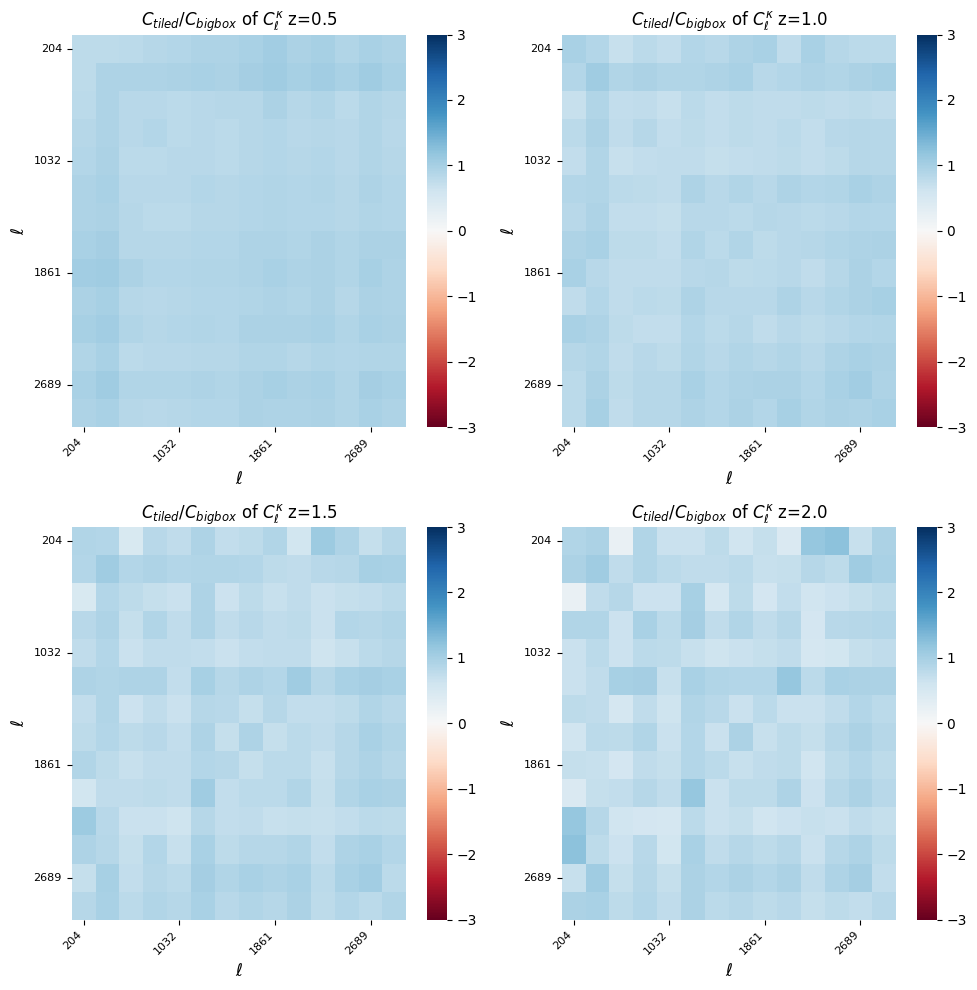

In [71]:
# Assuming correlation_bigbox, correlation_tiled, and ell are already defined
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes = axes.flatten()  # Flatten the 2x2 array of axes

# Define the interval for ticks
tick_interval = 4

for i, ax in enumerate(axes):
    # Create the heatmap
    sns.heatmap(cov_ratios[i], ax=ax, cmap='RdBu', center=0, xticklabels=ell, yticklabels=ell, vmin=-3, vmax=3)
    
    # Set the title
    ax.set_title(r"$C_{tiled}/C_{bigbox}$ of $C_{\ell}^\kappa$"+f" z={zs_list[i]}", fontsize=12)
    
    # Apply the ticks and labels only for every nth element
    ax.set_xticks(ax.get_xticks()[::tick_interval])
    ax.set_xticklabels([f'{tick:.0f}' for tick in ell[::tick_interval]], rotation=45, ha='right', fontsize=8)
    ax.set_yticks(ax.get_yticks()[::tick_interval])
    ax.set_yticklabels([f'{tick:.0f}' for tick in ell[::tick_interval]], rotation=0, fontsize=8)
    
    # Add x and y axis labels
    ax.set_xlabel(r'$\ell$', fontsize=12)
    ax.set_ylabel(r'$\ell$', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

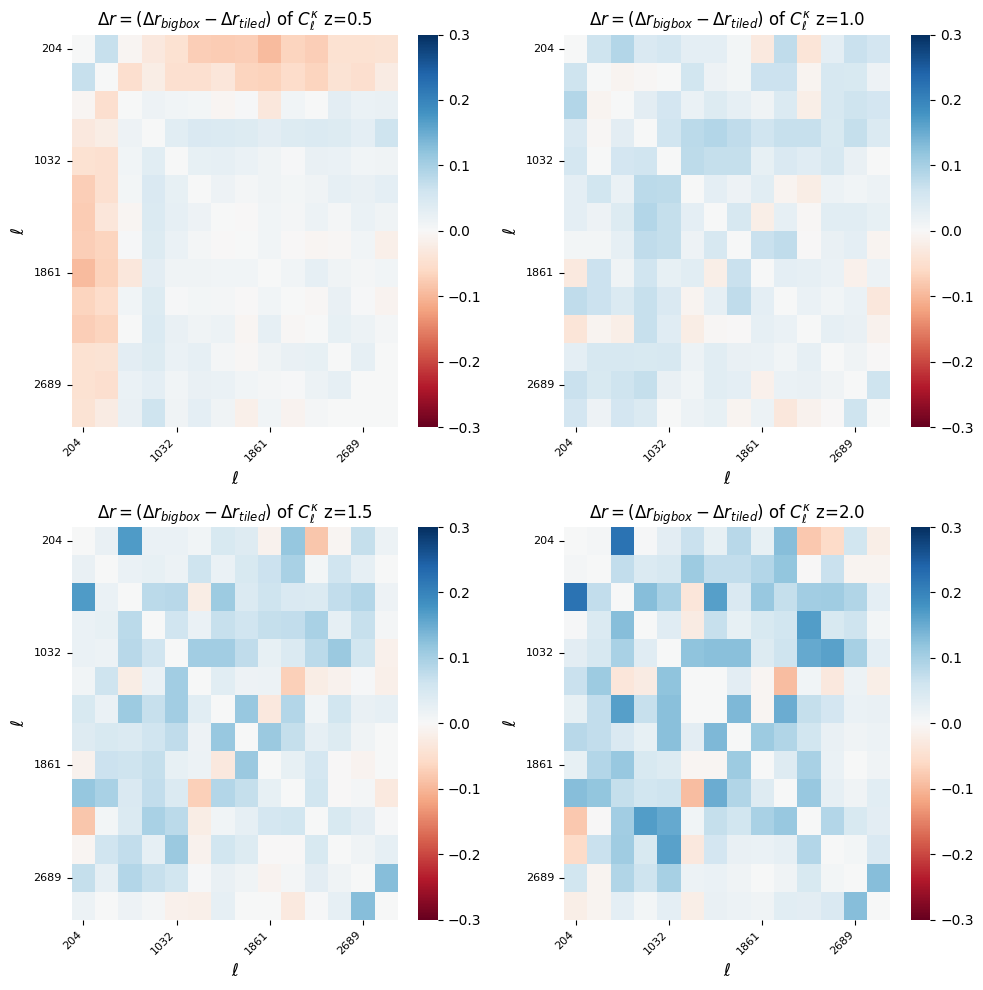

In [63]:
# Assuming correlation_bigbox, correlation_tiled, and ell are already defined
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes = axes.flatten()  # Flatten the 2x2 array of axes

# Define the interval for ticks
tick_interval = 4

for i, ax in enumerate(axes):
    # Create the heatmap
    sns.heatmap(correlation_differences[i], ax=ax, cmap='RdBu', center=0, xticklabels=ell, yticklabels=ell, vmin=-0.3, vmax=0.3)
    
    # Set the title
    ax.set_title(r"$\Delta r = (\Delta r_{bigbox} - \Delta r_{tiled})$ of $C_{\ell}^\kappa$"+f" z={zs_list[i]}", fontsize=12)
    
    # Apply the ticks and labels only for every nth element
    ax.set_xticks(ax.get_xticks()[::tick_interval])
    ax.set_xticklabels([f'{tick:.0f}' for tick in ell[::tick_interval]], rotation=45, ha='right', fontsize=8)
    ax.set_yticks(ax.get_yticks()[::tick_interval])
    ax.set_yticklabels([f'{tick:.0f}' for tick in ell[::tick_interval]], rotation=0, fontsize=8)
    
    # Add x and y axis labels
    ax.set_xlabel(r'$\ell$', fontsize=12)
    ax.set_ylabel(r'$\ell$', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


# PDF

In [43]:
def calculate_pdf(data):
    pdfs = [np.load(f)['p'] for f in data]
    nu = np.load(data[0])['nu']
    pdfs = np.array(pdfs)

    return pdfs, nu

def compute_pdf_correlation(config_id, source_redshift):
    results_directory = os.path.join(config_analysis.resultsdir, config_id)
    kappa_map_files = glob(os.path.join(results_directory, "PDF", "patch_flat", f"zs{source_redshift:.1f}", '*.npz'))

    pdfs, nu = calculate_pdf(kappa_map_files)

    cov_pdf = np.cov(pdfs, rowvar=False)

    diagonal_terms = np.diag(cov_pdf)
    correlation = cov_pdf / np.sqrt(diagonal_terms[:, None] * diagonal_terms[None, :])

    return correlation, nu, cov_pdf

In [44]:
zs_list = [0.5, 1.0, 1.5, 2.0]
correlation_differences =[]
cov_ratios= []
for source_redshift in zs_list:
    correlation_tiled, ell, cov_pdf_tiled = compute_pdf_correlation("tiled", source_redshift)
    correlation_bigbox, _, cov_pdf_bigbox = compute_pdf_correlation("bigbox", source_redshift)
    cov_ratios.append(cov_pdf_tiled / cov_pdf_bigbox)
    correlation_differences.append(correlation_bigbox - correlation_tiled)

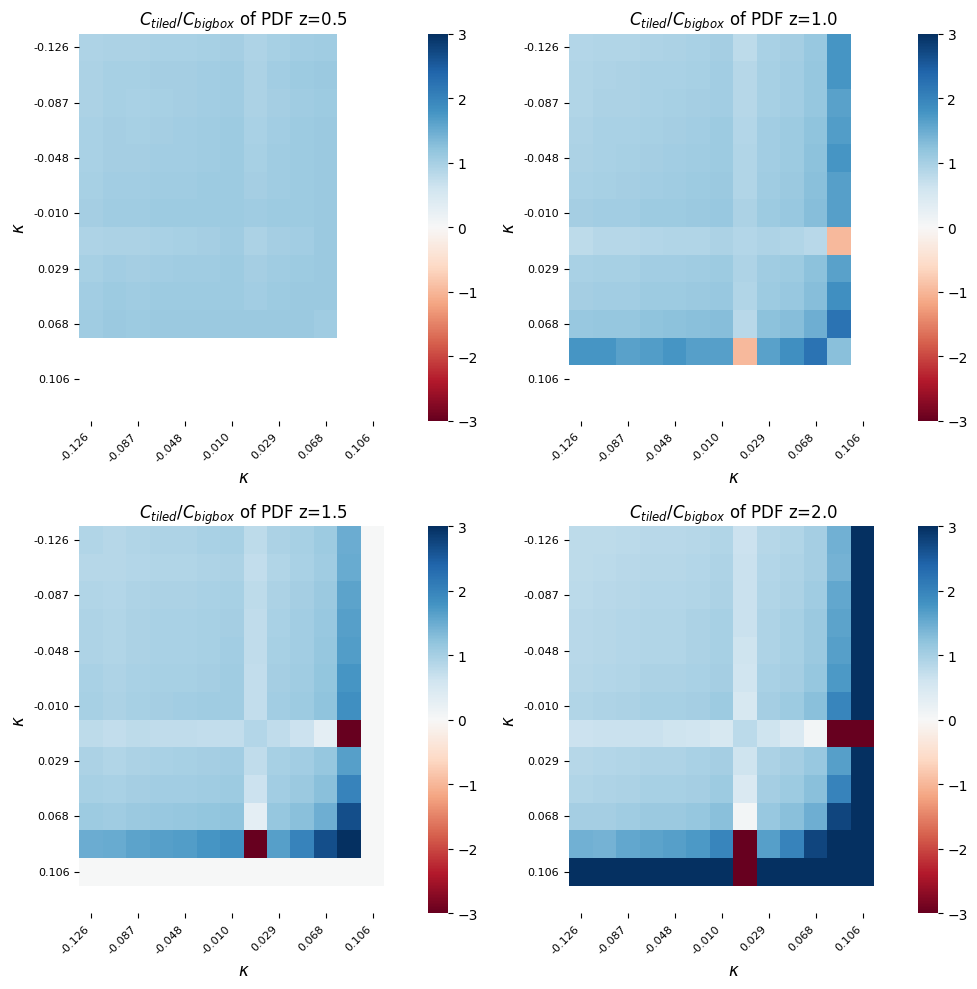

In [49]:
# Assuming correlation_bigbox, correlation_tiled, and ell are already defined
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes = axes.flatten()  # Flatten the 2x2 array of axes

# Define the interval for ticks
tick_interval = 2

for i, ax in enumerate(axes):
    # Create the heatmap
    sns.heatmap(cov_ratios[i], ax=ax, cmap='RdBu', center=0, xticklabels=ell, yticklabels=ell, vmin=-3, vmax=3)
    
    # Set the title
    ax.set_title(r"$C_{tiled}/C_{bigbox}$ of PDF"+f" z={zs_list[i]}", fontsize=12)
    
    # Apply the ticks and labels only for every nth element
    ax.set_xticks(ax.get_xticks()[::tick_interval])
    ax.set_xticklabels([f'{tick:.3f}' for tick in ell[::tick_interval]], rotation=45, ha='right', fontsize=8)
    ax.set_yticks(ax.get_yticks()[::tick_interval])
    ax.set_yticklabels([f'{tick:.3f}' for tick in ell[::tick_interval]], rotation=0, fontsize=8)
    
    # Add x and y axis labels
    ax.set_xlabel(r'$\kappa$', fontsize=12)
    ax.set_ylabel(r'$\kappa$', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

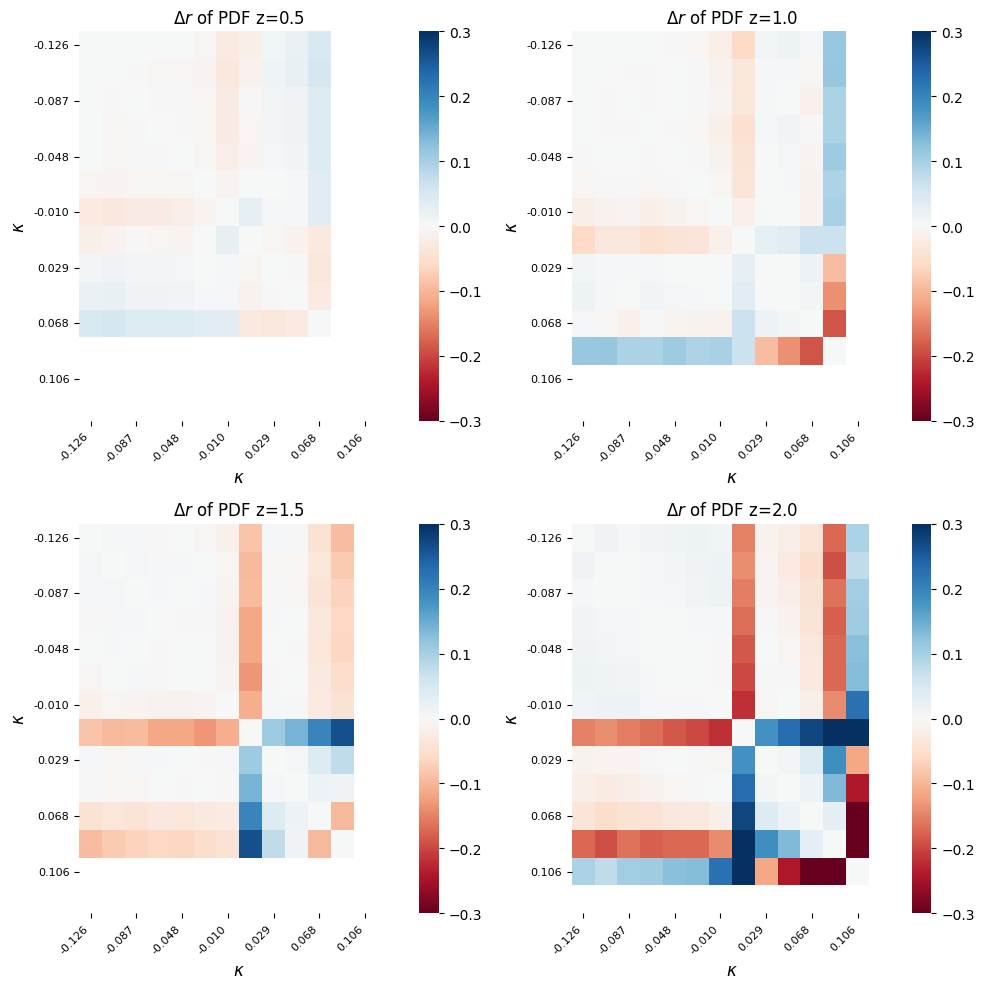

In [51]:
# Assuming correlation_bigbox, correlation_tiled, and ell are already defined
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes = axes.flatten()  # Flatten the 2x2 array of axes

# Define the interval for ticks
tick_interval = 2

for i, ax in enumerate(axes):
    # Create the heatmap
    sns.heatmap(correlation_differences[i], ax=ax, cmap='RdBu', center=0, xticklabels=ell, yticklabels=ell, vmin=-0.3, vmax=0.3)
    
    # Set the title
    ax.set_title(r"$\Delta r$ of PDF"+f" z={zs_list[i]}", fontsize=12)
    
    # Apply the ticks and labels only for every nth element
    ax.set_xticks(ax.get_xticks()[::tick_interval])
    ax.set_xticklabels([f'{tick:.3f}' for tick in ell[::tick_interval]], rotation=45, ha='right', fontsize=8)
    ax.set_yticks(ax.get_yticks()[::tick_interval])
    ax.set_yticklabels([f'{tick:.3f}' for tick in ell[::tick_interval]], rotation=0, fontsize=8)
    
    # Add x and y axis labels
    ax.set_xlabel(r'$\kappa$', fontsize=12)
    ax.set_ylabel(r'$\kappa$', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()